## Import Packages Etc

In [11]:
from IPython.display import display, HTML, Image

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn.datasets import load_iris
from sklearn.ensemble import BaggingClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold

%matplotlib inline
#%qtconsole

## Define StackedEnsembleClassifier

Utility function to create classifer objects based on a name

In [12]:
def create_classifier(classifier_type, tree_min_samples_split = 20):

    if classifier_type == "svm":
        c = svm.SVC(probability=True)

    elif classifier_type == "logreg":
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)

    elif classifier_type == "knn":
        c = neighbors.KNeighborsClassifier()

    elif classifier_type == "tree":
        c = tree.DecisionTreeClassifier(min_samples_split = tree_min_samples_split)

    elif classifier_type == "randomforest":
        c = ensemble.RandomForestClassifier()
        
    else:
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
    
    return c

StackedEnsembleClassifier class.

In [13]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregation model at the aggregation layer. A k-fold cross validation is used to generate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier 
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
          
        # Train each base classifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)

            # Append the predictions ot the stack layer training set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Test the StackedEnsembleClassifier

Perform a simple test using the StackedEnsembleClassifier on the Iris dataset

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleClassifier()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.96      0.97        50
           2       0.96      0.98      0.97        50

   micro avg       0.98      0.98      0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

Confusion Matrix


C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,1,49,50
All,50,49,51,150


Perform a cross validation experiment

In [5]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

## Task 1: Design the StackedEnsembleHoldOut Class

In [15]:
# Write your code here
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierHoldOut(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregation model at the aggregation layer. A k-fold cross validation is used to generate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifierHoldOut()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg", hold_out_percentage = 0.7):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.hold_out_percentage = hold_out_percentage

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        #X_train = X
        #y_train = y
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, train_size = self.hold_out_percentage)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_valid
          
        # Train each base classifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_valid)

            # Append the predictions ot the stack layer training set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Task 2: Design the StackedEnsembleKFold Class

In [31]:
# Write your code here
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierKFold(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregation model at the aggregation layer. A k-fold cross validation is used to generate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg", kFold=5):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.kFold = kFold

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
        
        print("Number of classifiers", self.n_estimators_)
        
        folds = KFold(n_splits=self.kFold, shuffle=True, random_state=1)
        
        self.X_stack_train_combine = None #(dtype = float)
        self.y_stack_train = []
        
        for train_index, test_index in folds.split(X):
            
            X_train = X[train_index]
            X_test = X[test_index]
            y_train = y[train_index]
            y_test = y[test_index]
            
            try:
                self.y_stack_train = np.r_[self.y_stack_train, y_test]
            except ValueError:
                self.y_stack_train = y_test
            
            # Set up empty arrays to hold stack layer training data
            self.X_stack_train = None #(dtype = float)
          
            # Train each base classifier and generate the stack layer training dataset
            for classifier in self.classifiers_:

                # Extract a bootstrap sample
                X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
                # Train a base classifier
                classifier.fit(X_train_samp, y_train_samp)
            
                # Make predictions for all instances in the training set
                y_pred = classifier.predict_proba(X_test)

                # Append the predictions ot the stack layer training set (a bit of hacking here!)
                try:
                    self.X_stack_train = np.c_[self.X_stack_train, y_pred]
                except ValueError:
                    self.X_stack_train = y_pred
            
            try:
                self.X_stack_train_combine = np.r_[self.X_stack_train_combine, self.X_stack_train]
            except ValueError:
                self.X_stack_train_combine = self.X_stack_train
        
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train_combine, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Task 3: Compare the Performance of Different Stack Layer Approaches

In [23]:
# Read the dataset
data_train = pd.read_csv('fashion-mnist_train.csv')
data_test = pd.read_csv('fashion-mnist_test.csv')

data_train = shuffle(data_train, random_state=0)
data_test = shuffle(data_test, random_state=0)

data_train = data_train.sample(frac=0.1)
data_test = data_test.sample(frac=0.1)

# Remove later
#data_train = data_train.head(2000)
#data_test = data_test.head(2000)

# Check for presence of missing values
print("Missing Values in train")
print(data_train.isnull().sum())

# Check for presence of missing values
print("Missing Values in test")
print(data_test.isnull().sum())

mnist_train_target = data_train["label"]
#print(mnist_train_target.head())

#mnist_train_data = data_train.iloc[:,1:]

mnist_train_data = data_train.drop(['label'], 1)
#print(mnist_train_data.head())

mnist_test_target = data_test["label"]
#print(mnist_test_target.head())

#mnist_test_data = data_test.iloc[:,1:]
mnist_test_data = data_test.drop(['label'], 1)

#print(mnist_test_data.head())

Missing Values in train
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
pixel29     0
           ..
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64
Missing Values in test
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pix

In [25]:
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

### StackedEnsembleClassifier

In [26]:
clf = StackedEnsembleClassifier()
clf.fit(mnist_train_data, mnist_train_target)

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='logreg')

In [27]:
y_pred = clf.predict(mnist_test_data)

accuracy = metrics.accuracy_score(mnist_test_target, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["StackedEnsembleClassifier"] = accuracy
print("Accuracy: " +  str(accuracy))

print(metrics.classification_report(mnist_test_target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(mnist_test_target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.786
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        86
           1       0.95      0.94      0.95       106
           2       0.60      0.71      0.65        96
           3       0.75      0.87      0.80        90
           4       0.62      0.61      0.61       102
           5       0.92      0.83      0.87        86
           6       0.63      0.49      0.55       120
           7       0.90      0.86      0.88       104
           8       0.90      0.94      0.92       110
           9       0.86      0.95      0.90       100

   micro avg       0.79      0.79      0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.78      1000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,61,0,3,7,3,0,7,0,5,0,86
1,0,100,1,5,0,0,0,0,0,0,106
2,3,0,68,2,15,0,7,0,1,0,96
3,1,2,0,78,4,0,5,0,0,0,90
4,0,1,20,5,62,1,13,0,0,0,102
5,0,0,0,0,0,71,0,6,4,5,86
6,16,2,22,6,13,0,59,0,2,0,120
7,0,0,0,0,0,4,0,89,0,11,104
8,0,0,0,1,2,1,3,0,103,0,110


In [ ]:
scores = cross_val_score(clf, mnist_test_data, mnist_test_target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

### StackedEnsembleClassifierHoldOut

In [28]:
clf = StackedEnsembleClassifierHoldOut()
clf.fit(mnist_train_data, mnist_train_target)

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account bette

StackedEnsembleClassifierHoldOut(base_estimator_duplicates=8,
                 base_estimator_types=['svm', 'logreg', 'tree'],
                 hold_out_percentage=0.7,
                 stack_layer_classifier_type='logreg')

In [29]:
y_pred = clf.predict(mnist_test_data)

accuracy = metrics.accuracy_score(mnist_test_target, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["StackedEnsembleClassifierHoldOut"] = accuracy
print("Accuracy: " +  str(accuracy))

print(metrics.classification_report(mnist_test_target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(mnist_test_target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.778
              precision    recall  f1-score   support

           0       0.66      0.64      0.65        86
           1       0.93      0.94      0.94       106
           2       0.59      0.61      0.60        96
           3       0.75      0.88      0.81        90
           4       0.59      0.62      0.61       102
           5       0.94      0.86      0.90        86
           6       0.60      0.47      0.52       120
           7       0.89      0.88      0.89       104
           8       0.92      0.97      0.95       110
           9       0.88      0.93      0.90       100

   micro avg       0.78      0.78      0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.77      0.78      0.77      1000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,55,0,4,7,1,1,13,0,5,0,86
1,0,100,0,6,0,0,0,0,0,0,106
2,6,0,59,0,24,0,6,0,1,0,96
3,0,5,0,79,3,0,3,0,0,0,90
4,1,1,15,6,63,0,16,0,0,0,102
5,0,0,0,0,0,74,0,5,3,4,86
6,21,1,21,8,13,0,56,0,0,0,120
7,0,0,0,0,0,3,0,92,0,9,104
8,0,0,1,0,1,1,0,0,107,0,110


In [ ]:
scores = cross_val_score(clf, mnist_test_data, mnist_test_target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

### StackedEnsembleClassifierKFold

In [32]:
clf = StackedEnsembleClassifierKFold(kFold=5)
clf.fit(mnist_train_data, mnist_train_target)

Number of classifiers 24


C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

StackedEnsembleClassifierKFold(base_estimator_duplicates=8,
                base_estimator_types=['svm', 'logreg', 'tree'], kFold=5,
                stack_layer_classifier_type='logreg')

In [33]:
y_pred = clf.predict(mnist_test_data)

accuracy = metrics.accuracy_score(mnist_test_target, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["StackedEnsembleClassifierKFold"] = accuracy
print("Accuracy: " +  str(accuracy))

print(metrics.classification_report(mnist_test_target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(mnist_test_target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.793
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        86
           1       0.97      0.95      0.96       106
           2       0.58      0.70      0.63        96
           3       0.73      0.89      0.80        90
           4       0.67      0.61      0.64       102
           5       0.94      0.86      0.90        86
           6       0.65      0.48      0.56       120
           7       0.93      0.87      0.90       104
           8       0.89      0.96      0.93       110
           9       0.87      0.95      0.91       100

   micro avg       0.79      0.79      0.79      1000
   macro avg       0.79      0.80      0.79      1000
weighted avg       0.79      0.79      0.79      1000

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,60,0,6,6,1,0,8,0,5,0,86
1,0,101,0,5,0,0,0,0,0,0,106
2,2,0,67,1,16,0,8,0,2,0,96
3,2,3,1,80,2,0,2,0,0,0,90
4,0,0,20,8,62,0,11,0,1,0,102
5,0,0,0,0,0,74,0,3,4,5,86
6,21,0,21,8,11,0,58,0,1,0,120
7,0,0,0,0,0,5,0,90,0,9,104
8,0,0,0,1,1,0,2,0,106,0,110


In [ ]:
scores = cross_val_score(clf, mnist_test_data, mnist_test_target, cv=5)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

## Task 4: Comparing the Performance of Different Stack Layer Approaches with  More Standard Approaches

## Decision Tree Classifier

In [34]:
# Write your code here
clf = DecisionTreeClassifier()
clf.fit(mnist_train_data, mnist_train_target)
y_pred = clf.predict(mnist_test_data)

accuracy = metrics.accuracy_score(mnist_test_target, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["DecisionTreeClassifier"] = accuracy
print("Accuracy: " +  str(accuracy))

print(metrics.classification_report(mnist_test_target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(mnist_test_target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.679
              precision    recall  f1-score   support

           0       0.66      0.57      0.61        86
           1       0.91      0.91      0.91       106
           2       0.52      0.64      0.57        96
           3       0.64      0.68      0.66        90
           4       0.44      0.42      0.43       102
           5       0.76      0.65      0.70        86
           6       0.53      0.45      0.49       120
           7       0.79      0.78      0.78       104
           8       0.78      0.82      0.80       110
           9       0.75      0.88      0.81       100

   micro avg       0.68      0.68      0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,49,0,7,8,1,0,14,1,5,1,86
1,0,96,1,6,1,0,2,0,0,0,106
2,3,0,61,4,19,0,8,0,1,0,96
3,4,8,1,61,8,0,3,0,1,4,90
4,0,0,25,10,43,1,19,0,4,0,102
5,0,1,0,0,0,56,0,13,5,11,86
6,17,1,14,4,21,2,54,1,6,0,120
7,0,0,0,0,0,10,0,81,3,10,104
8,1,0,7,2,4,2,1,0,90,3,110


In [ ]:
scores = cross_val_score(clf, mnist_test_data, mnist_test_target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

Tuning the parameters of Decision tree using exhaustive GridSearch

In [35]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(clf, param_grid, cv=10, verbose = 2, return_train_score=True)
my_tuned_tree.fit(mnist_train_data, mnist_train_target)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 .............

[CV]  criterion=gini, max_depth=21, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=21, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=21, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=21, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=21, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=21, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=21, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=21, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=21, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=21, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=21, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=21, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=21, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=21, min_samples_split=200 ......

[CV]  criterion=gini, max_depth=36, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=36, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=36, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=36, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=36, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=39, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=39, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=39, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=39, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=39, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=39, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=39, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=39, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=39, min_samples_split=200 ......

[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.7s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.7s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.7s
[CV] criterion=entropy, max_depth=9, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=200, total=   0.9s
[CV] criterion=entropy, max_depth=9, min_samples_

[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.7s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.7s
[CV] criterion=entropy, max_depth=24, min_

[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.7s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.7s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=42, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=42, min_samples_split=200, total=   0.7s
[CV] criterion=entropy, max_depth=42, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=42, min_samples_split=200, total=   0.7s
[CV] criterion=entropy, max_depth=42, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=42, min_samples_split=200, total=   0.7s
[CV] criterion=entropy, max_depth=42, min_

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  3.4min finished
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:


{'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 200}

0.713

{'mean_fit_time': array([0.20247538, 0.31490638, 0.30281174, 0.30491185, 0.3834641 ,
        0.41024702, 0.40115304, 0.3968555 , 0.39575684, 0.40834856,
        0.39475694, 0.40125337, 0.39655621, 0.42463877, 0.3520833 ,
        0.30561123, 0.49089823, 0.76712821, 0.98249509, 1.0199718 ,
        0.99188993, 0.97729833, 0.79221168, 0.73055053, 0.84348142,
        0.98879106, 0.98079674, 0.99908454, 0.78841484, 0.74564106,
        0.90964034, 0.97480059]),
 'std_fit_time': array([0.01306246, 0.01902786, 0.00731579, 0.00856725, 0.04301124,
        0.01560695, 0.01095884, 0.00999857, 0.0078941 , 0.02058495,
        0.00536398, 0.0105227 , 0.00826391, 0.02743645, 0.04373444,
        0.00790473, 0.0108259 , 0.03074256, 0.02255777, 0.05795365,
        0.03727138, 0.02015941, 0.11084617, 0.02026581, 0.12229134,
        0.02090615, 0.02341269, 0.03276923, 0.05853383, 0.0293298 ,
        0.09163392, 0.02109695]),
 'mean_score_time': array([0.00150011, 0.00149958, 0.00139918, 0.0015996 , 0.001799

In [36]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(mnist_test_data)

# Print performance details
accuracy = metrics.accuracy_score(mnist_test_target, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Tuned Tree"] = accuracy

print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(mnist_test_target, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(mnist_test_target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.659
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        86
           1       0.98      0.76      0.86       106
           2       0.48      0.66      0.56        96
           3       0.57      0.73      0.64        90
           4       0.50      0.42      0.46       102
           5       0.64      0.69      0.66        86
           6       0.40      0.30      0.34       120
           7       0.84      0.78      0.81       104
           8       0.71      0.81      0.76       110
           9       0.80      0.90      0.85       100

   micro avg       0.66      0.66      0.66      1000
   macro avg       0.67      0.66      0.66      1000
weighted avg       0.67      0.66      0.66      1000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,51,0,9,9,2,3,10,0,2,0,86
1,0,81,4,17,0,0,1,0,3,0,106
2,1,0,63,1,16,0,14,0,1,0,96
3,0,2,8,66,0,3,6,0,5,0,90
4,0,0,16,8,43,0,24,0,11,0,102
5,0,0,0,0,0,59,0,12,3,12,86
6,16,0,23,12,25,0,36,0,8,0,120
7,0,0,0,0,0,12,0,81,0,11,104
8,0,0,6,2,0,12,0,1,89,0,110


## Bagging Classifier

In [37]:
clf = DecisionTreeClassifier()
num_trees = 24

model = BaggingClassifier(base_estimator=clf, n_estimators=num_trees, random_state=7)
model.fit(mnist_train_data, mnist_train_target)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=24, n_jobs=None, oob_score=False,
         random_state=7, verbose=0, warm_start=False)

In [38]:
y_pred = model.predict(mnist_test_data)
accuracy = metrics.accuracy_score(mnist_test_target, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["BaggingClassifier"] = accuracy
print("Accuracy: " +  str(accuracy))

print(metrics.classification_report(mnist_test_target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(mnist_test_target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.789
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        86
           1       0.93      0.91      0.92       106
           2       0.62      0.73      0.67        96
           3       0.72      0.87      0.78        90
           4       0.68      0.68      0.68       102
           5       0.87      0.88      0.88        86
           6       0.65      0.45      0.53       120
           7       0.90      0.82      0.86       104
           8       0.93      0.95      0.94       110
           9       0.89      0.96      0.92       100

   micro avg       0.79      0.79      0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,60,1,3,8,2,1,8,0,3,0,86
1,0,96,1,8,0,0,1,0,0,0,106
2,5,1,70,0,14,1,5,0,0,0,96
3,1,3,2,78,3,0,3,0,0,0,90
4,1,0,13,8,69,0,10,0,1,0,102
5,0,0,0,0,0,76,0,7,2,1,86
6,23,1,19,7,13,1,54,0,2,0,120
7,0,0,0,0,0,8,0,85,0,11,104
8,0,1,2,0,0,0,2,0,105,0,110


In [ ]:
scores = cross_val_score(model, mnist_test_data, mnist_test_target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

Tuning the parameters of Bagging using exhaustive GridSearch

In [39]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(model, param_grid, cv=10, verbose = 2)
my_tuned_model.fit(mnist_train_data, mnist_train_target)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   7.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50, total=   7.7s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_spli

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=100, total=  15.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=150, total=  22.9s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=150 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=200, total=  31.0s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=200 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=250, total=  45.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=250 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=300, total=  50.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=300 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=350, total= 1.0min
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=350 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=400, total= 1.1min
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=400 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=450, total= 1.2min
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=500 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_sp

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 83.0min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 50}
0.434


In [40]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(mnist_test_data)

# Print performance details
accuracy = metrics.accuracy_score(mnist_test_target, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(mnist_test_target, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(mnist_test_target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.555
              precision    recall  f1-score   support

           0       0.50      0.74      0.60        86
           1       0.55      0.88      0.68       106
           2       0.46      0.84      0.60        96
           3       0.00      0.00      0.00        90
           4       0.39      0.50      0.44       102
           5       0.69      0.23      0.35        86
           6       0.00      0.00      0.00       120
           7       0.64      0.78      0.70       104
           8       0.81      0.65      0.72       110
           9       0.61      0.93      0.74       100

   micro avg       0.56      0.56      0.56      1000
   macro avg       0.47      0.56      0.48      1000
weighted avg       0.46      0.56      0.48      1000

Confusion Matrix


C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,0,1,2,4,5,7,8,9,All
True,,,,,,,,,
0,64,5,10,2,0,2,3,0,86
1,6,93,4,0,0,0,0,3,106
2,2,1,81,11,0,0,1,0,96
3,23,54,6,1,0,1,0,5,90
4,2,7,32,51,0,1,9,0,102
5,0,0,0,0,20,32,2,32,86
6,31,6,31,49,0,1,2,0,120
7,0,0,0,0,8,81,0,15,104
8,0,2,9,17,0,6,72,4,110


## Task 5: Implement the StackedEnsembleOneVsOne Class

In [41]:
# Write your code here
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierOneVsOne(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregation model at the aggregation layer. A k-fold cross validation is used to generate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_type = "svm", stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_type: The type of classifiers to include at the base layer
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_type = base_estimator_type
        self.base_estimator_type_list = list()
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        #print("X shape:",X.shape)
        #print("y shape:",y.shape)
        
        #print("X", X)
        #print("y", y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        label_count = len(self.classes_)
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        count = 0
        
        # Add all the classifiers
        for i in range(label_count):
            for j in range(i+1,label_count):
                
                # Create classifier before training it
                t = self.base_estimator_type
                self.base_estimator_type_list.append(t)
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)        
                
        ########################
        # LEVEL 0
        ########################
        
        # Initialize the variables
        self.X_stack_train_combine = None #(dtype = float)
        self.y_stack_train = []
        
        # Create nC2 number of models, where n is the number of labels
        for i in range(label_count):
            #self.X_stack_train = None
            for j in range(i+1,label_count):
                indices = np.where((y == i) | (y == j))[0]
                X_temp = X[list(indices)]
                y_temp = y[list(indices)]
                
                self.X_stack_train = None
                
                # Train test split
                X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, random_state=0, test_size=0.5)
                
                # Append the test split
                try:
                    self.y_stack_train = np.r_[self.y_stack_train, y_test]
                except ValueError:
                    self.y_stack_train = y_test
                
                # Iterate over all the classifiers
                for classifier in self.classifiers_:
                        
                    # Extract a bootstrap sample
                    X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)
                
                    # Train a base classifier
                    classifier.fit(X_train_samp, y_train_samp)
                
                    # Make predictions for all instances in the training set
                    y_pred = classifier.predict_proba(X_test)

                    # Append the predictions ot the stack layer training set (a bit of hacking here!)
                    try:
                        self.X_stack_train = np.c_[self.X_stack_train, y_pred]
                    except ValueError:
                        self.X_stack_train = y_pred
                
                # Append the predicted values to be passed to the stack layer
                try:
                    self.X_stack_train_combine = np.r_[self.X_stack_train_combine, self.X_stack_train]
                except ValueError:
                    self.X_stack_train_combine = self.X_stack_train
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train_combine, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_X_y(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Task 6 Evaluate the Performance of the StackedEnsembleClassifierOneVsOne Algorithm

In [42]:
# Write your code here
clf = StackedEnsembleClassifierOneVsOne()
clf.fit(mnist_train_data, mnist_train_target)

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

StackedEnsembleClassifierOneVsOne(base_estimator_type='svm',
                 stack_layer_classifier_type='logreg')

In [43]:
y_pred = clf.predict(mnist_test_data)

accuracy = metrics.accuracy_score(mnist_test_target, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["StackedEnsembleClassifierOneVsOne"] = accuracy
print("Accuracy: " +  str(accuracy))

print(metrics.classification_report(mnist_test_target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(mnist_test_target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        86
           1       0.00      0.00      0.00       106
           2       0.00      0.00      0.00        96
           3       0.00      0.00      0.00        90
           4       0.00      0.00      0.00       102
           5       0.00      0.00      0.00        86
           6       0.00      0.00      0.00       120
           7       0.00      0.00      0.00       104
           8       0.00      0.00      0.00       110
           9       0.10      1.00      0.18       100

   micro avg       0.10      0.10      0.10      1000
   macro avg       0.01      0.10      0.02      1000
weighted avg       0.01      0.10      0.02      1000

Confusion Matrix


C:\Users\Salman\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,9.0,All
True,,
0,86,86
1,106,106
2,96,96
3,90,90
4,102,102
5,86,86
6,120,120
7,104,104
8,110,110


In [ ]:
scores = cross_val_score(clf, mnist_test_data, mnist_test_target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

## Task 7 Reflect on the Performance of the Different Models Evaluated

*Write your reflection here (max 300 words)*

The focus of this assignment is to evaluate the performance of various Stacking based Ensemble models

The models are run with 10% of data(6000 rows) after sampling. Evaluation metric values for each of the classifier is as displayed above. I have chosen accuracy and F1-Score as a measure of evaluating the performance of these models. The accuracy of different models is displayed below.

StackedEnsembleClassifier gave an accuracy of 0.786 and F1-score of 0.78

StackedEnsembleClassifierHoldOut gave an accuracy of 0.778 and F1-score of 0.77

StackedEnsembleClassifierKFold gave an accuracy of 0.793 and F1-score of 0.79

Decision tree gave an accuracy of 0.679 and F1-score of 0.68

Tuned Decision tree gave an accuracy of 0.659 and F1-score of 0.66

Bagging with decision tree gave an accuracy of 0.789 and F1-score of 0.79

Tuned Bagging gave an accuracy of 0.555 and F1-score of 0.48

StackedEnsembleOneVsOne gave an accuracy of 0.7933333333333 and F1-score of 0.79

It can be inferred from the above results that ensemble techniques perform better than the single models. This is because each model in an ensemble specializes parts of the data. When all these models are combined, the model performs better than individual models.

We have used two ensemble techniques here. They are Bagging and Stacking. We have used Bagging implementation from sklearn and implemented stacking using the individual models. Bagging and Stacking provide almost similar results when the metrics are compared.
We have implemented different stacking approaches for implementing the stacking ensemble.

The basic stacking model, StackedEnsembleClassifier provided good values. But the implementation is not efficient. We are using the same data for training and valdating which might impose overfitting.

StackedEnsembleClassifierHoldOut model is a good implementation of stacking and has a split of train and valid set in the training data. It removes the effect of overfitting and provides a reliable measure of accuracy.

StackedEnsembleClassifierKFold model is an improvement over holdOut model. It improves the accuracy by splitting the data using K-Fold validation method.

StackedEnsembleClassifierOneVsOne model provides specialization over parts of the data and is a good implementation of the stacking based of model. It compares almost similar to KFold approach when trained with full dataset, but provides more robustness and suits best to the concept of an ensemble.

Decision tree classifier performs not so well when compared with the ensemble models.

Bagging is an improvement over single decision tree and compares well with stacking based model.

GridSearch provides exhaustive search mechanism to choose hyperparameters for the model. We have seen that it improves the performance of both basic and ensemble based models.

So in terms of performance, the order would be as follows

Decision_tree > Bagging > StackingClassifier > StackingholdOut > Stacking1vs1 > StackingKFold 



In [44]:
display(model_valid_accuracy_comparisons)

{'StackedEnsembleClassifier': 0.786,
 'StackedEnsembleClassifierHoldOut': 0.778,
 'StackedEnsembleClassifierKFold': 0.793,
 'DecisionTreeClassifier': 0.679,
 'Tuned Tree': 0.659,
 'BaggingClassifier': 0.789,
 'Tuned Bagging': 0.555,
 'StackedEnsembleClassifierOneVsOne': 0.1}

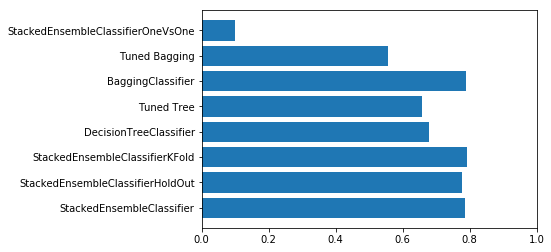

In [45]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))
